<div style="display: flex; align-items: center;">
    <img alt="udeA logo" height="140px" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true" style="width:107px;height:152px; margin-right: 40px;">
    <div style="text-align: center;">
        <h1><b><font color='0B5345'>Proyecto 4: Clasificación de señales ECG</font></b></h1>
        <h2><font color='0B5345'>Proyecto 2024-02</font></h2>
        <h3><font color='0B5345'>Luisa Fernanda Enciso - Jader Chingal</font></h3>
    </div>
</div>

In [287]:
import neurokit2 as nk
import pandas as pd
import seaborn as sns
import scipy.signal as signal
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import random
from scipy.signal import butter, filtfilt
import pywt
from scipy.signal import detrend
import warnings
from scipy.signal import welch
from sklearn.metrics import mean_squared_error
from skimage.restoration import denoise_nl_means, estimate_sigma
from scipy.signal import savgol_filter
from statsmodels.nonparametric.smoothers_lowess import lowess

from itertools import product

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer

# Imagen más grande
plt.rcParams['figure.figsize'] = [15, 5]  
plt.rcParams['font.size']= 14

# Ignorar todos los warnings 
warnings.filterwarnings("ignore", category=UserWarning)  # Para warnings de tipo UserWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)  # Para warnings de tipo RuntimeWarning

<hr>

# Funciones

In [288]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Matriz de confusión',cmap=plt.cm.Blues):
    """
    Esta función imprime y grafica la matriz de confusión.
    La normalización puede aplicarse si se establece `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión, sin normalización')

    print(cm)
    
    # Crear la figura para la matriz de confusión
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Agregar los valores en cada celda de la matriz
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Etiqueta predicha')




<hr>

Extracción de los registros que corresponden a bradicardia sinusal (SB Sinus Bradycardia) y fibrilación auricular (AFIB Atrial Fibrillation). 

In [289]:
# Cargar el archivo Excel en un DataFrame
ruta=r"C:\Users\luisa\OneDrive - Universidad de Antioquia\Documentos\BIOSENALES24II\Proyecto2\Diagnostics.xlsx"
diagnostics_df = pd.read_excel(ruta)

# Crear el nuevo dataframe filtrando por la columna 'Rhythm'
datos_filtred = diagnostics_df[(diagnostics_df['Rhythm'] == 'SB') | (diagnostics_df['Rhythm'] == 'AFIB')]

# Discriminar datos de acuerdo a su caracteristica 
datos_SB = diagnostics_df[(diagnostics_df['Rhythm'] == 'SB')]
datos_AFIB = diagnostics_df[(diagnostics_df['Rhythm'] == 'AFIB')]

# Convertir la columna 'FileName' en una lista de Python
datos_listaF = datos_filtred['FileName'].tolist()

datos_lista_SB = datos_SB['FileName'].tolist()
datos_lista_AFIB = datos_AFIB['FileName'].tolist()

datos_filtred.head()

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
5,MUSE_20180112_120347_79000,SB,NONE,46,FEMALE,57,57,70,404,393,38,24,9,225,260,427
6,MUSE_20180114_075026_69000,AFIB,TWC,80,FEMALE,98,86,74,360,459,69,83,17,215,252,395


In [290]:
# Imprimir los tamaños de las listas
print(f"Tamaño total de Datos (SB + AFIB): {len(datos_listaF)}")
print(f"Tamaño de (SB): {len(datos_lista_SB)}")
print(f"Tamaño de (AFIB): {len(datos_lista_AFIB)}")

Tamaño total de Datos (SB + AFIB): 5669
Tamaño de (SB): 3889
Tamaño de (AFIB): 1780


<hr>

### Seleccionar señales de la base de datos.

In [291]:
# Definir la ruta del archivo donde se guardarán los nombres de archivo seleccionados
archivo_seleccion = r"C:\Users\luisa\OneDrive - Universidad de Antioquia\Documentos\BIOSENALES24II\Proyecto4\seleccion_filename.txt"

# Comprobar si el archivo de selección ya existe
if os.path.exists(archivo_seleccion):
    # Cargar los nombres de archivo previamente guardados
    with open(archivo_seleccion, "r") as f:
        seleccion = f.read().splitlines()
    seleccion_SB = seleccion[:3]
    seleccion_AFIB = seleccion[3:]
else:
    # Si el archivo no existe, realizar una selección aleatoria y guardarla
    seleccion_SB = random.sample(datos_SB['FileName'].tolist(), 3)
    seleccion_AFIB = random.sample(datos_AFIB['FileName'].tolist(), 3)
    
    # Guardar solo los nombres de archivo en el archivo de texto
    with open(archivo_seleccion, "w") as f:
        for filename in seleccion_SB + seleccion_AFIB:
            f.write(f"{filename}\n")

# Imprimir las selecciones
print("Señales seleccionadas de SB:", seleccion_SB)
print("Señales seleccionadas de AFIB:", seleccion_AFIB)

Señales seleccionadas de SB: ['MUSE_20180116_130648_60000', 'MUSE_20180115_133308_88000', 'MUSE_20180119_175736_85000']
Señales seleccionadas de AFIB: ['MUSE_20180116_123051_48000', 'MUSE_20180113_171327_27000', 'MUSE_20180119_173941_98000']


<hr>

## Aplicar tutorial de NeuroKit

In [292]:

def neurokit_ecg(subject_list, data_path=r"C:\Users\luisa\Downloads\ECGDataDenoised\ECGDataDenoised", sampling_rate=500):
    # Definir las columnas esperadas
    columns = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    # Recorrer la lista de sujetos
    for subject_file in subject_list:
        # Asegurarse de que la lista no tenga extensión y agregarla
        subject_file_with_extension = f"{subject_file}.csv"

        # Ruta del archivo CSV del sujeto
        data_subject = os.path.join(data_path, subject_file_with_extension)

        # Cargar el archivo CSV con las columnas especificadas
        df = pd.read_csv(data_subject, delimiter=',', names=columns)

        # Asegurarse de que la columna 'II' está presente
        if 'II' not in df.columns:
            raise ValueError(f"La columna 'II' no se encuentra en el archivo {subject_file_with_extension}")
        
        # Extraer la derivación II (la señal original)
        signal = df['II'].to_numpy()  # Almacenar como un array de numpy

        # Procesar la señal ECG con NeuroKit2
        ecg_Signals_Process, infoProcess = nk.ecg_process(signal, sampling_rate=sampling_rate)

        # Graficar los primeros 5000 puntos de la señal procesada
        nk.ecg_plot(ecg_Signals_Process[:5000], infoProcess)

        # Detectar picos en la señal
        Peaks, infopeaks = nk.ecg_peaks(signal, sampling_rate=sampling_rate)

        # Calcular la variabilidad de la frecuencia cardíaca (HRV) en el dominio del tiempo
        hrv_time_ = nk.hrv_time(Peaks, sampling_rate=sampling_rate, show=True)
        
        # Mostrar el resultado de HRV
        print(f"HRV para el sujeto {subject_file_with_extension}:")
        print(hrv_time_)


### Aplicar Rutina Neurokit a Sujetos con SB

HRV para el sujeto MUSE_20180116_130648_60000.csv:
    HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  1202.285714  12.671678         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0         NaN         NaN   18.11077  19.839355  ...        6.0     0.699676   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0       1196.0       1203.2        0.0  28.571429     1194.0     1230.0   

   HRV_HTI  HRV_TINN  
0     1.75       0.0  

[1 rows x 25 columns]
HRV para el sujeto MUSE_20180115_133308_88000.csv:
   HRV_MeanNN  HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0     1048.25  9.647353         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0         NaN         NaN  15.212777  16.077195  ...       19.0     0.634161   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20 

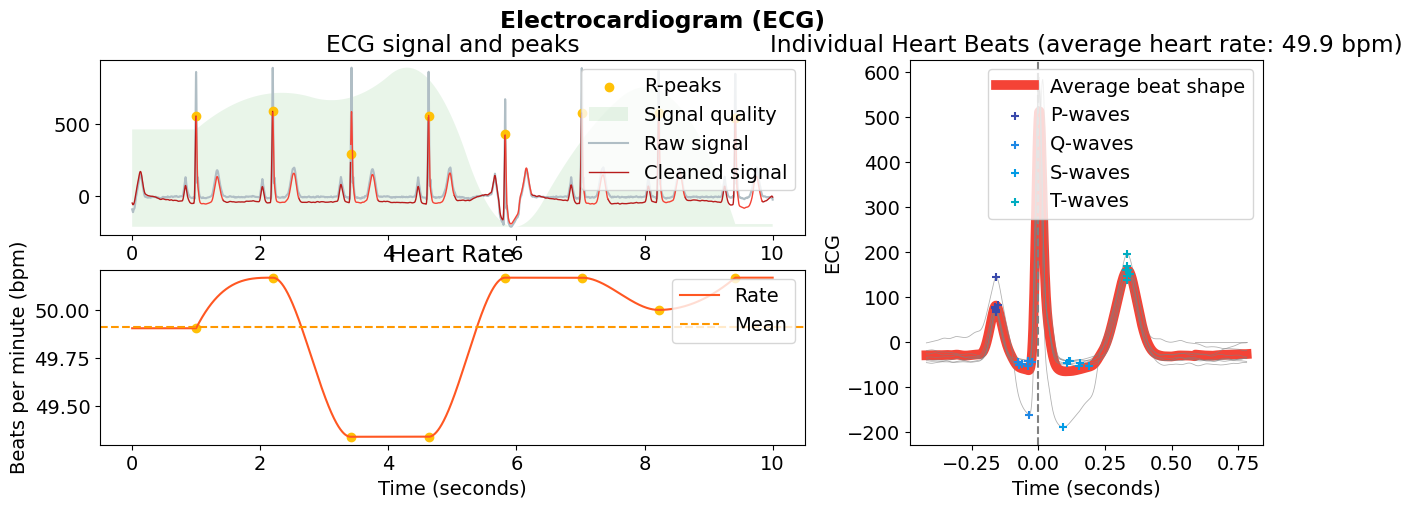

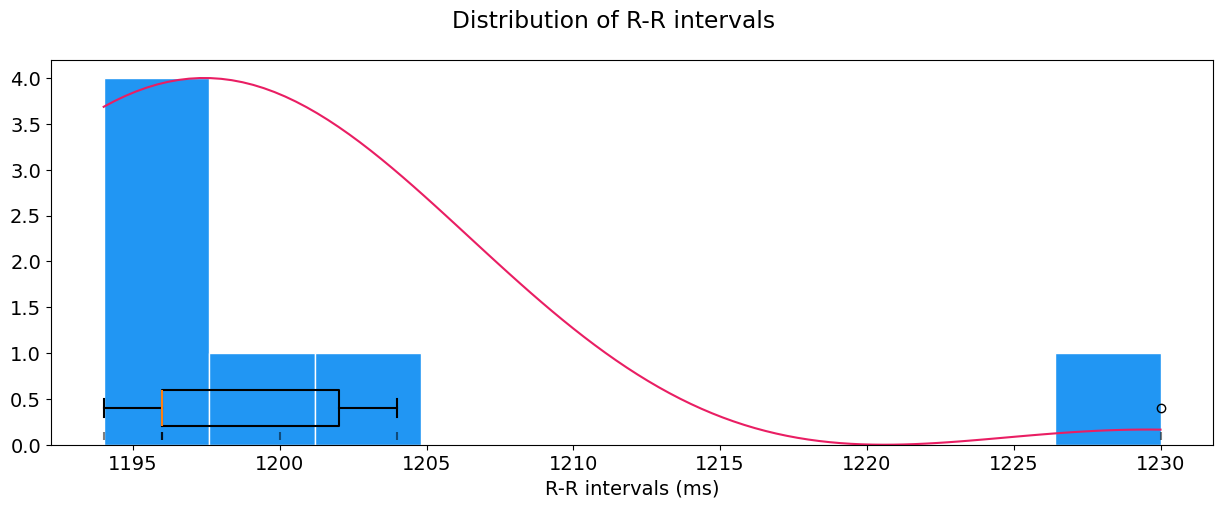

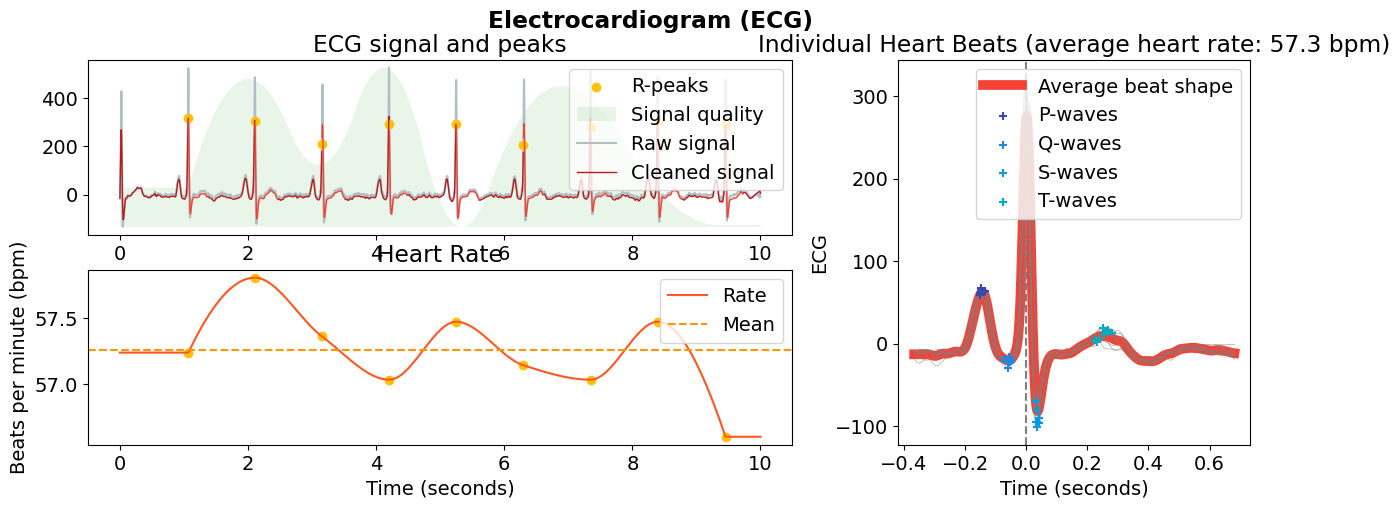

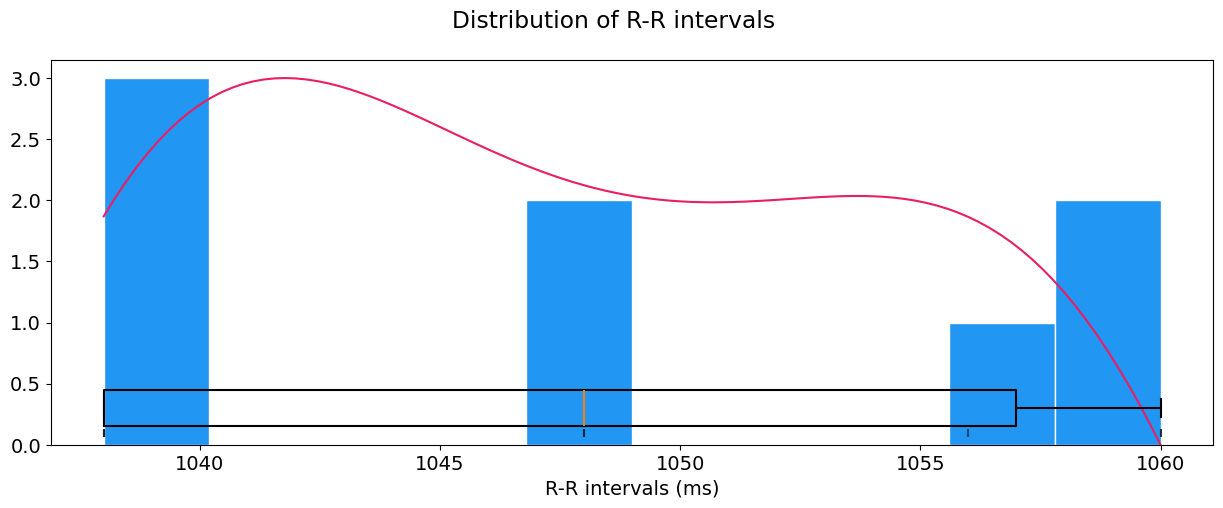

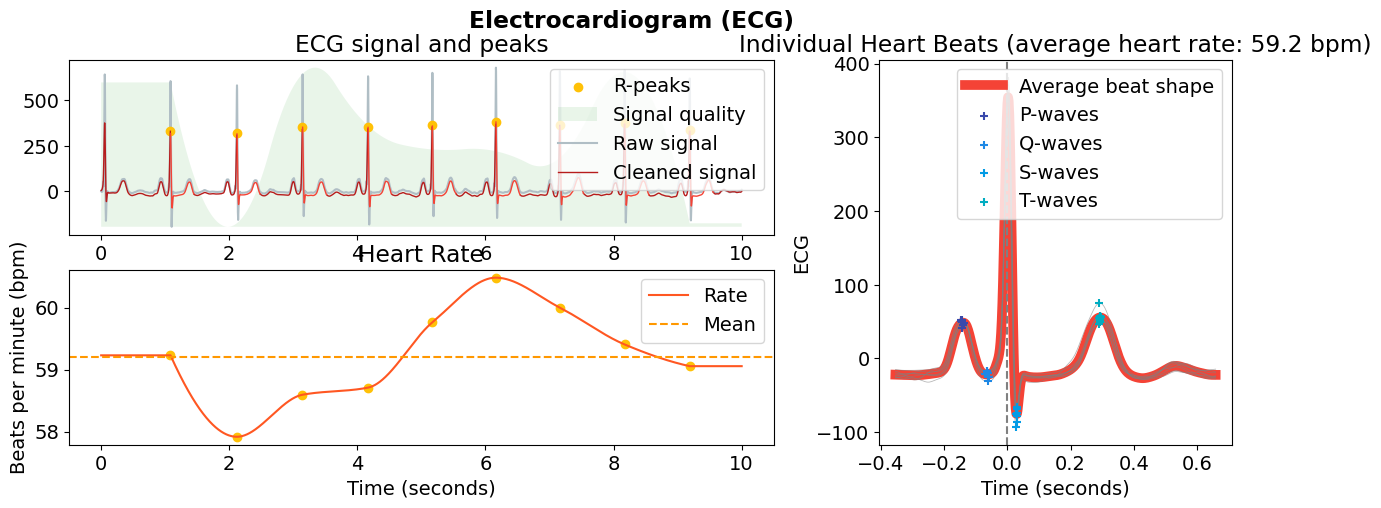

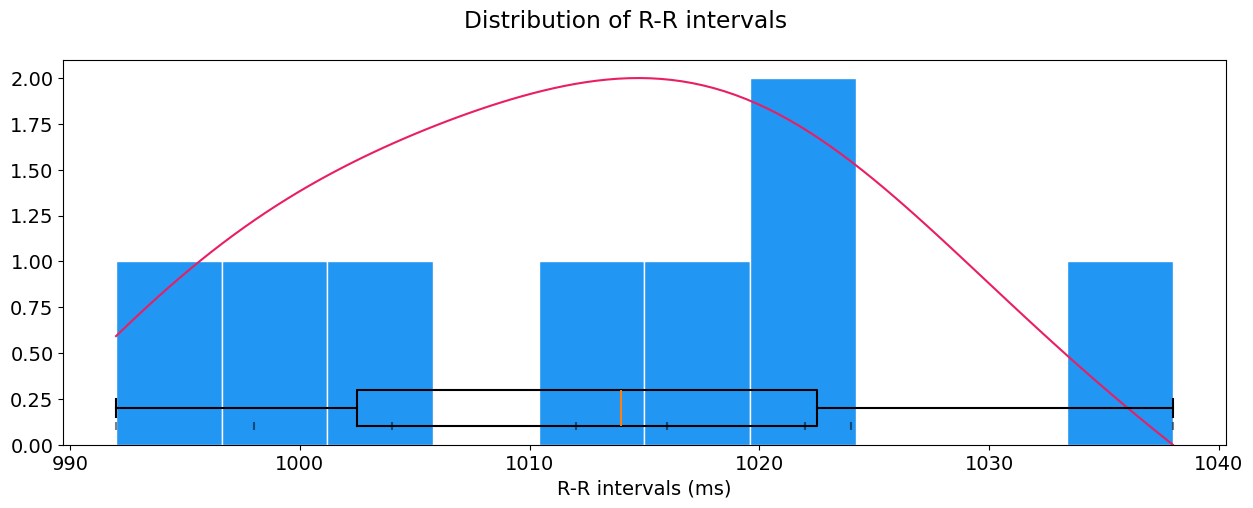

In [293]:
neurokit_ecg(seleccion_SB)

### Aplicar Rutina Neurokit a Sujetos con AFIB

HRV para el sujeto MUSE_20180116_123051_48000.csv:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0       798.2  299.480216         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0         NaN         NaN  416.997202  437.993151  ...      462.0   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     0.718183        546.0       1090.0       80.0       80.0      438.0   

   HRV_MaxNN  HRV_HTI  HRV_TINN  
0     1326.0     10.0       0.0  

[1 rows x 25 columns]
HRV para el sujeto MUSE_20180113_171327_27000.csv:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  512.555556  51.090718         NaN         NaN         NaN         NaN   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD  HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0         NaN         NaN  81.263551  83.70519  ...       65.5     0.628704   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pN

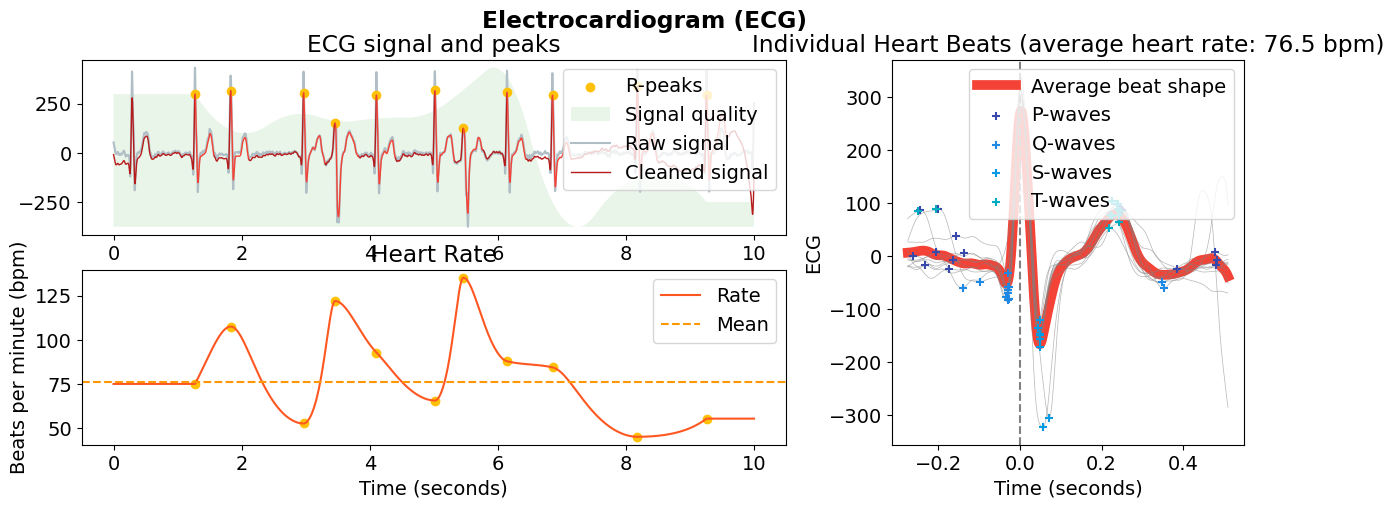

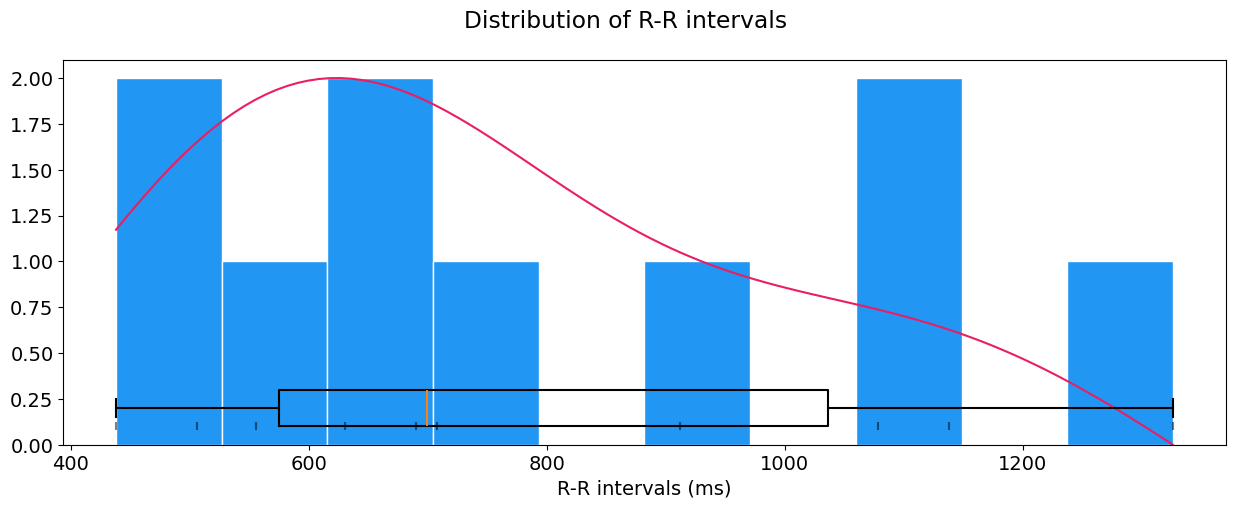

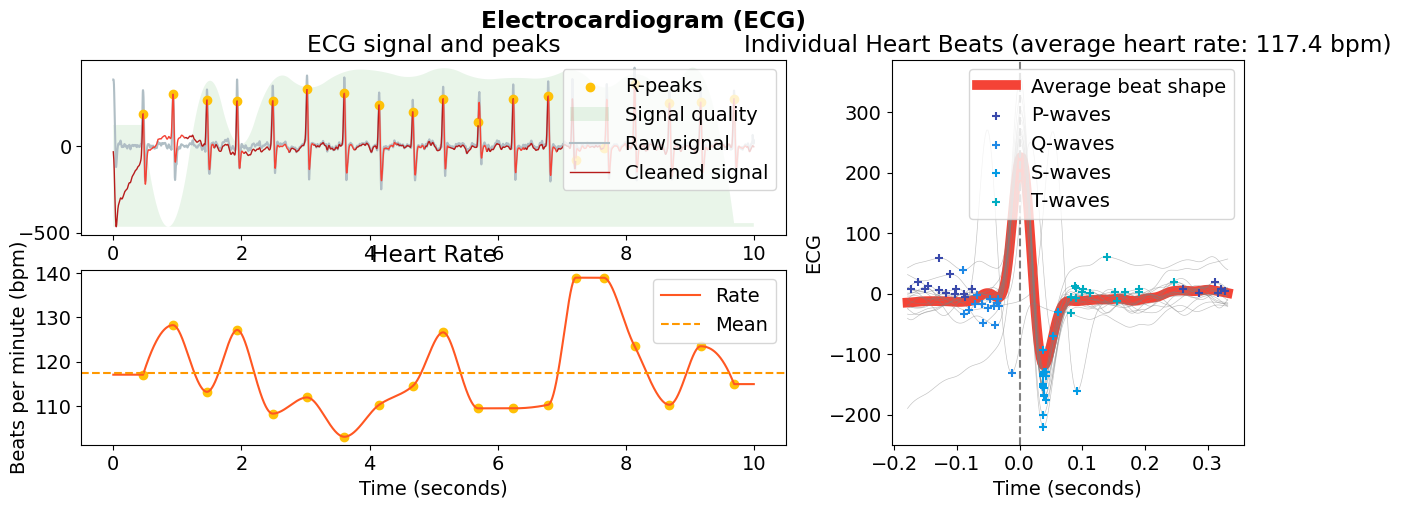

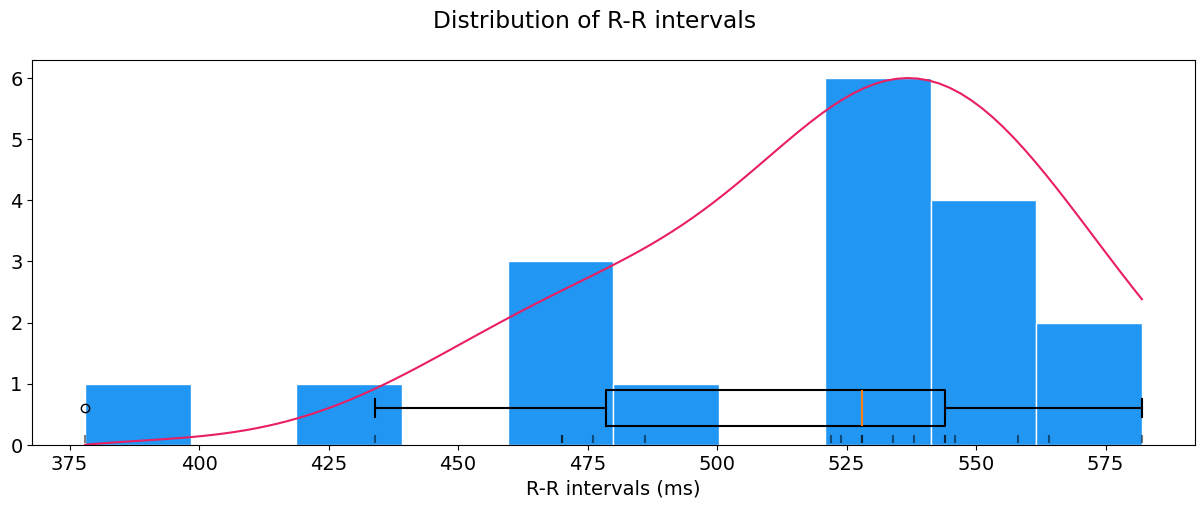

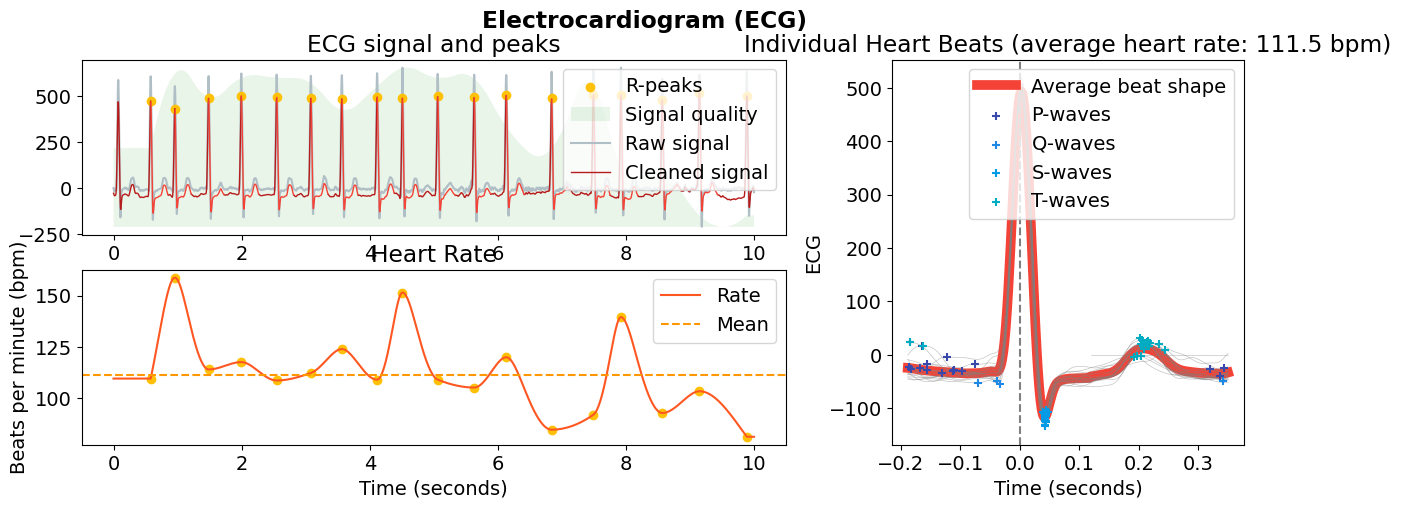

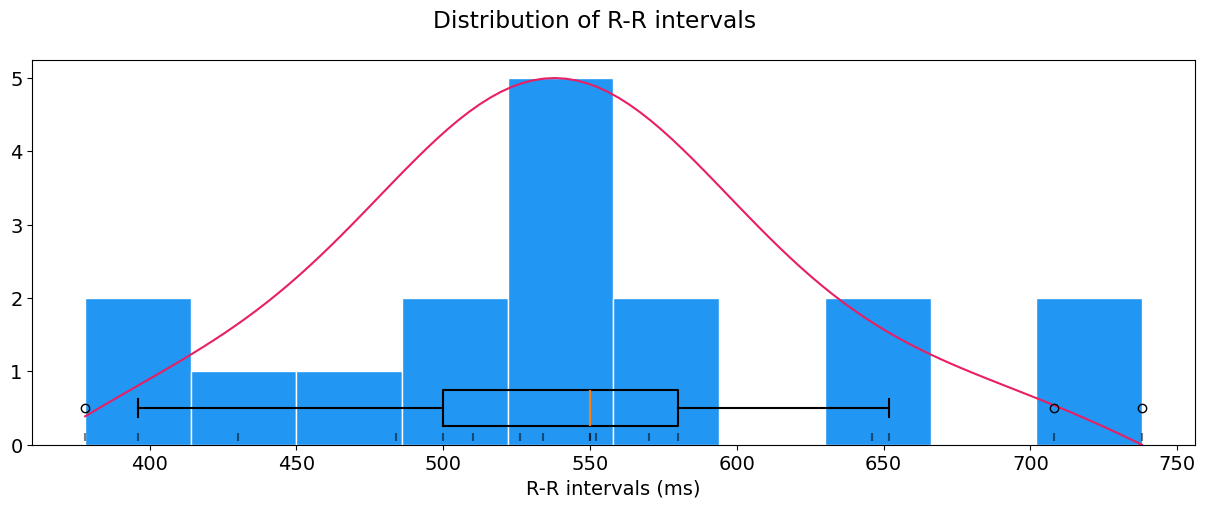

In [294]:
neurokit_ecg(seleccion_AFIB)

<hr>

### Características a extraer:

1. Ventricular rate in beats per minute (BPM)
2. Atrial rate in BPM
3. QRSCount
4. IntervalRR
5. TOffset
6. PhaseVentricular diastolic
7. Phase ventricular sistolic
8. QRSDuration
9. Sexo 
10. Edad 
11. fMP 


<hr>

### Crear una rutina que aplique sobre todos los archivos de la base de datos la rutina 5 y almacene los resultados en un dataframe

In [295]:
def process_ecg_data_list(subject_list, save_path_results):
    """
    Procesa una lista de sujetos y guarda los resultados en un archivo CSV. 
    Si el archivo ya existe, no realiza ninguna acción.
    """
    # Verificar si el archivo results.csv ya existe
    if os.path.exists(save_path_results):
        print(f"El archivo '{save_path_results}' ya existe. No se realizó ningún procesamiento.")
        return None

    # Ruta donde están los archivos de señales ECG
    data_path = r"C:\Users\luisa\Downloads\ECGDataDenoised\ECGDataDenoised"
    
    # Ruta del archivo "results.csv" que contiene la característica fMP
    results_path = r"C:\Users\luisa\OneDrive - Universidad de Antioquia\Documentos\BIOSENALES24II\Proyecto2\results.csv"
    results_df = pd.read_csv(results_path)

    # Ruta del archivo de información del paciente (patient_info.csv)
    patient_info_path = r"C:\Users\luisa\OneDrive - Universidad de Antioquia\Documentos\BIOSENALES24II\Proyecto2\Diagnostics.xlsx"
    patient_info_df = pd.read_excel(patient_info_path)

    # DataFrame para almacenar todos los resultados
    all_results = pd.DataFrame()

    # Listas para rastrear errores
    errores = []
    procesados = []

    # Definir las columnas esperadas en los archivos de señales
    columns = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    # Procesar cada archivo en la lista
    for subject_file in subject_list:
        subject_file_with_extension = f"{subject_file}.csv"
        data_subject = os.path.join(data_path, subject_file_with_extension)

        try:
            # Comprobar si el archivo existe
            if not os.path.exists(data_subject):
                raise FileNotFoundError(f"Archivo no encontrado: {data_subject}")

            # Cargar el archivo CSV
            df = pd.read_csv(data_subject, delimiter=',', names=columns)

            if 'II' not in df.columns:
                raise ValueError(f"La columna 'II' no se encuentra en el archivo {subject_file_with_extension}")

            # Extraer la derivación II
            signal = df['II'].to_numpy()

            # Procesar la señal ECG
            ecg_Signals_Process, infoProcess = nk.ecg_process(signal, sampling_rate=500)

            # Calcular los parámetros específicos
            R_peaks = infoProcess['ECG_R_Peaks']
            RR_intervals = np.diff(R_peaks) / 500
            VentricularRate_avg = 60 / np.mean(RR_intervals)

            p_peaks = np.array(infoProcess['ECG_P_Peaks'])
            p_peaks_cleaned = p_peaks[~np.isnan(p_peaks)]
            atrial_rate = 60 / np.mean(np.diff(p_peaks_cleaned) / 500)

            QRS_count = len(infoProcess['ECG_R_Peaks'])
            interval_RR = np.mean(RR_intervals)

            t_offsets = np.array(infoProcess["ECG_T_Offsets"])
            t_offsets_avg = np.mean(t_offsets[~np.isnan(t_offsets)] / 500)

            ventricular_phase = ecg_Signals_Process["ECG_Phase_Ventricular"].values
            systole_count = len(ventricular_phase[ventricular_phase == 1])
            diastole_count = len(ventricular_phase[ventricular_phase == 0])

            # Extraer información de fMP
            subject_results = results_df[results_df['Archivo'] == subject_file]
            fMP = subject_results['fMP'].values[0] if not subject_results.empty else np.nan

            # Buscar información del paciente 
            patient_data = patient_info_df[patient_info_df['FileName'] == subject_file]
            patient_age = patient_data['PatientAge'].values[0] if not patient_data.empty else np.nan
            patient_gender = patient_data['Gender'].values[0] if not patient_data.empty else np.nan
            patient_QRSDuration = patient_data['QRSDuration'].values[0] if not patient_data.empty else np.nan
            patient_Rhythm = patient_data['Rhythm'].values[0] if not patient_data.empty else np.nan

            # Crear un DataFrame con los resultados del sujeto
            result_df = pd.DataFrame({
                'FileName': [subject_file],
                'Rythm':[patient_Rhythm],
                'PatientAge': [patient_age],
                'Gender': [patient_gender],
                'VentricularRate': [VentricularRate_avg],
                'AtrialRate': [atrial_rate],
                'QRSCount': [QRS_count],
                'RRInterval': [interval_RR],
                'TOffsets': [t_offsets_avg],
                'PhaseSystolic': [systole_count],
                'PhaseDiastolic': [diastole_count],
                'QRSDuration': [patient_QRSDuration],
                'fMP': [fMP]
            })

            # Agregar al DataFrame de resultados consolidados
            all_results = pd.concat([all_results, result_df], ignore_index=True)
            procesados.append(subject_file)

            print(f"Procesado con éxito: {subject_file}")

        except Exception as e:
            print(f"Error procesando el archivo {subject_file_with_extension}: {e}")
            errores.append((subject_file, str(e)))

    # Guardar el DataFrame consolidado
    all_results.to_csv(save_path_results, index=False)

    # Reportar los archivos no procesados
    no_procesados = [subject for subject in subject_list if subject not in procesados]
    print("\nResumen del procesamiento:")
    print(f"Total sujetos procesados: {len(procesados)}")
    print(f"Total sujetos no procesados: {len(no_procesados)}")
    print(f"Sujetos no procesados: {no_procesados}")

    # Registrar errores
    if errores:
        print("\nErrores detectados:")
        for error in errores:
            print(f"Sujeto: {error[0]}, Error: {error[1]}")

    return all_results


<hr>

## Procesar todos los sujetos

In [296]:
# Llamar la función con una ruta para guardar los resultados
save_path_results = r"C:\Users\luisa\OneDrive - Universidad de Antioquia\Documentos\BIOSENALES24II\Proyecto4\results.csv"
process_ecg_data_list(datos_listaF, save_path_results)

El archivo 'C:\Users\luisa\OneDrive - Universidad de Antioquia\Documentos\BIOSENALES24II\Proyecto4\results.csv' ya existe. No se realizó ningún procesamiento.


<hr>

In [297]:

df = pd.read_csv(r"C:\Users\luisa\OneDrive - Universidad de Antioquia\Documentos\BIOSENALES24II\Proyecto4\results.csv")
# Verificar los primeros registros del DataFrame procesado
df.head()

,FileName,Rythm,PatientAge,Gender,VentricularRate,AtrialRate,QRSCount,RRInterval,TOffsets,PhaseSystolic,PhaseDiastolic,QRSDuration,fMP
0,MUSE_20180113_171327_27000,AFIB,85,MALE,117.060481,110.066499,19,0.512556,5.399647,1852,2860,114,9.0
1,MUSE_20180112_073319_29000,SB,59,FEMALE,51.698671,51.660517,8,1.160571,5.509250,1467,2780,92,2.6
2,MUSE_20180113_121940_44000,SB,66,MALE,53.309640,53.309640,9,1.125500,5.123000,1581,2922,96,0.9
3,MUSE_20180112_120347_79000,SB,46,FEMALE,56.617127,56.590427,9,1.059750,5.030000,1564,2849,70,3.8
4,MUSE_20180114_075026_69000,AFIB,80,FEMALE,95.703956,89.039644,16,0.626933,5.050400,2289,2414,74,4.2


<hr>

### Modificar el dataframe para que tenga la estructura deseada para la red

In [298]:
# Paso 1: Leer el archivo CSV
df = pd.read_csv(r"C:\Users\luisa\OneDrive - Universidad de Antioquia\Documentos\BIOSENALES24II\Proyecto4\results.csv")

# Paso 2: Codificar la columna 'Gender' a valores binarios (0: Female, 1: Male)
df['Gender'] = df['Gender'].map({'MALE': 1, 'FEMALE': 0})

# Paso 3: Codificar la columna 'Rhythm' a valores binarios (0: SB, 1: AFIB)
df['Rythm'] = df['Rythm'].map({'SB': 0, 'AFIB': 1})

# Paso 4: Guardar el DataFrame procesado en un nuevo archivo CSV
df.to_csv(r"C:\Users\luisa\OneDrive - Universidad de Antioquia\Documentos\BIOSENALES24II\Proyecto4\processed_results.csv", index=False)

# Verificar los primeros registros del DataFrame procesado
df.head()

,FileName,Rythm,PatientAge,Gender,VentricularRate,AtrialRate,QRSCount,RRInterval,TOffsets,PhaseSystolic,PhaseDiastolic,QRSDuration,fMP
0,MUSE_20180113_171327_27000,1,85,1,117.060481,110.066499,19,0.512556,5.399647,1852,2860,114,9.0
1,MUSE_20180112_073319_29000,0,59,0,51.698671,51.660517,8,1.160571,5.509250,1467,2780,92,2.6
2,MUSE_20180113_121940_44000,0,66,1,53.309640,53.309640,9,1.125500,5.123000,1581,2922,96,0.9
3,MUSE_20180112_120347_79000,0,46,0,56.617127,56.590427,9,1.059750,5.030000,1564,2849,70,3.8
4,MUSE_20180114_075026_69000,1,80,0,95.703956,89.039644,16,0.626933,5.050400,2289,2414,74,4.2


In [299]:
df.describe()

,Rythm,PatientAge,Gender,VentricularRate,AtrialRate,QRSCount,RRInterval,TOffsets,PhaseSystolic,PhaseDiastolic,QRSDuration,fMP
count,5664.000000,5664.000000,5664.000000,5664.000000,5663.000000,5664.000000,5664.000000,5627.000000,5664.000000,5664.000000,5664.000000,5664.000000
mean,0.313559,63.045374,0.621116,68.698962,63.575769,11.081215,0.948946,5.316788,1883.453743,2591.077331,93.114054,3.194439
std,0.463980,14.867662,0.485152,23.558772,15.179366,3.753170,0.230180,0.466620,642.017687,612.928569,16.033815,2.797456
min,0.000000,10.000000,0.000000,28.125000,19.730352,4.000000,0.336786,0.560000,640.000000,0.000000,56.000000,0.100000
25%,0.000000,53.000000,0.000000,54.945055,54.704417,9.000000,0.770492,5.123292,1530.000000,2509.750000,82.000000,1.200000
50%,0.000000,64.000000,1.000000,58.013053,57.853010,9.000000,1.034250,5.323833,1671.000000,2751.000000,90.000000,2.800000
75%,1.000000,74.000000,1.000000,77.872279,70.241161,12.000000,1.092000,5.518944,1974.000000,2936.000000,100.000000,3.800000
max,1.000000,98.000000,1.000000,178.154825,137.548263,29.000000,2.133333,9.974000,4788.000000,3930.000000,206.000000,50.000000


<hr>

# Arquitectura 1: Factor 3

In [300]:
# Paso 1 - Crear arreglos para las características y la variable objetivo

target_column = ['Rythm']  # La columna que contiene las etiquetas (SB o AFIB)
predictors = list(set(list(df.columns))-set(target_column))  # Seleccionar las columnas que no sean 'Rythm'
print("Predictors:", predictors)  # Imprimir las columnas seleccionadas como predictores

# Excluir la columna 'FileName' de los predictores
predictors = [col for col in predictors if col != 'FileName']  # Filtrar 'FileName' para no incluirla en la normalización

# Filtrar solo las columnas numéricas para la normalización
numeric_predictors = df[predictors].select_dtypes(include=['number']).columns  # Seleccionar solo las columnas numéricas

# Normalizar solo las columnas numéricas
df[numeric_predictors] = df[numeric_predictors] / df[numeric_predictors].max()  # Normalización de las columnas numéricas

# Ver el resumen de estadísticas de las columnas después de la normalización
df.describe()  # Mostrar estadísticas descriptivas de las columnas


Predictors: ['Gender', 'FileName', 'AtrialRate', 'PhaseDiastolic', 'PhaseSystolic', 'fMP', 'QRSCount', 'QRSDuration', 'TOffsets', 'RRInterval', 'VentricularRate', 'PatientAge']


,Rythm,PatientAge,Gender,VentricularRate,AtrialRate,QRSCount,RRInterval,TOffsets,PhaseSystolic,PhaseDiastolic,QRSDuration,fMP
count,5664.000000,5664.000000,5664.000000,5664.000000,5663.000000,5664.000000,5664.000000,5627.000000,5664.000000,5664.000000,5664.000000,5664.000000
mean,0.313559,0.643320,0.621116,0.385614,0.462207,0.382111,0.444819,0.533065,0.393370,0.659307,0.452010,0.063889
std,0.463980,0.151711,0.485152,0.132238,0.110357,0.129420,0.107897,0.046784,0.134089,0.155961,0.077834,0.055949
min,0.000000,0.102041,0.000000,0.157868,0.143443,0.137931,0.157868,0.056146,0.133668,0.000000,0.271845,0.002000
25%,0.000000,0.540816,0.000000,0.308412,0.397711,0.310345,0.361168,0.513665,0.319549,0.638613,0.398058,0.024000
50%,0.000000,0.653061,1.000000,0.325633,0.420602,0.310345,0.484805,0.533771,0.348997,0.700000,0.436893,0.056000
75%,1.000000,0.755102,1.000000,0.437105,0.510666,0.413793,0.511875,0.553333,0.412281,0.747074,0.485437,0.076000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [301]:
# Paso 2 - Crear los conjuntos de entrenamiento y prueba
X = df[predictors].values  # Extraer las características (predictores) en una matriz de valores
y = df[target_column].values  # Extraer la variable objetivo ('Rythm') en una matriz de valores

# Se utiliza la misma semilla para la partición de los datos, asegurando que los resultados sean consistentes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)

# Se eliminan las dimensiones adicionales de y_train y y_test (en este caso, convertir de 2D a 1D)
y_test = np.squeeze(y_test)
y_train = np.squeeze(y_train)

# Imprimir las dimensiones de los conjuntos de entrenamiento y prueba
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de y_train:", y_train.shape)

print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_test:", y_test.shape)


Dimensiones de X_train: (3964, 11)
Dimensiones de y_train: (3964,)
Dimensiones de X_test: (1700, 11)
Dimensiones de y_test: (1700,)


In [302]:
# Paso 3 - Crear el Conjunto de Datos de Entrenamiento y Prueba
X = df[predictors].values
y = df[target_column].values

# El imputador para reemplazar NaN con la media de cada columna

imputer = SimpleImputer(strategy='mean')

# Imputamos los valores faltantes en los datos de entrenamiento y prueba
X_imputed = imputer.fit_transform(X)

# División en datos de entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.30, random_state=40)

# Aplanamos los datos de salida, si es necesario
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# Paso 4 - Entrenar el Modelo

# Creamos el clasificador MLP con 3 capas ocultas, cada una con 145 neuronas
mlp = MLPClassifier(hidden_layer_sizes=(145, 145, 145), activation='relu', solver='adam', max_iter=1000)
print(mlp)

# Entrenamos el clasificador utilizando los datos de entrenamiento
mlp.fit(X_train, y_train)

# Hacemos predicciones para los datos de entrenamiento y prueba
predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)



(3964, 11)
(3964,)
(1700, 11)
(1700,)
MLPClassifier(hidden_layer_sizes=(145, 145, 145), max_iter=1000)


In [303]:
# Resultados
# Matriz de confusión y reporte de clasificación para los datos de entrenamiento
from sklearn.metrics import confusion_matrix, classification_report

print("Matriz de confusión para los datos de entrenamiento:")
print(confusion_matrix(y_train, predict_train))

target_names = ['SB', 'AFIB']  
print("Reporte de clasificación para los datos de entrenamiento:")
print(classification_report(y_train, predict_train, target_names=target_names))

Matriz de confusión para los datos de entrenamiento:
[[2623   73]
 [  67 1201]]
Reporte de clasificación para los datos de entrenamiento:
              precision    recall  f1-score   support

          SB       0.98      0.97      0.97      2696
        AFIB       0.94      0.95      0.94      1268

    accuracy                           0.96      3964
   macro avg       0.96      0.96      0.96      3964
weighted avg       0.96      0.96      0.96      3964



In [304]:
# Matriz de confusión y reporte de clasificación para los datos de prueba
print("Matriz de confusión para los datos de prueba:")
print(confusion_matrix(y_test, predict_test))

print("Reporte de clasificación para los datos de prueba:")
print(classification_report(y_test, predict_test, target_names=target_names))

Matriz de confusión para los datos de prueba:
[[1143   49]
 [  33  475]]
Reporte de clasificación para los datos de prueba:
              precision    recall  f1-score   support

          SB       0.97      0.96      0.97      1192
        AFIB       0.91      0.94      0.92       508

    accuracy                           0.95      1700
   macro avg       0.94      0.95      0.94      1700
weighted avg       0.95      0.95      0.95      1700



Matriz de confusión, sin normalización
[[2623   73]
 [  67 1201]]


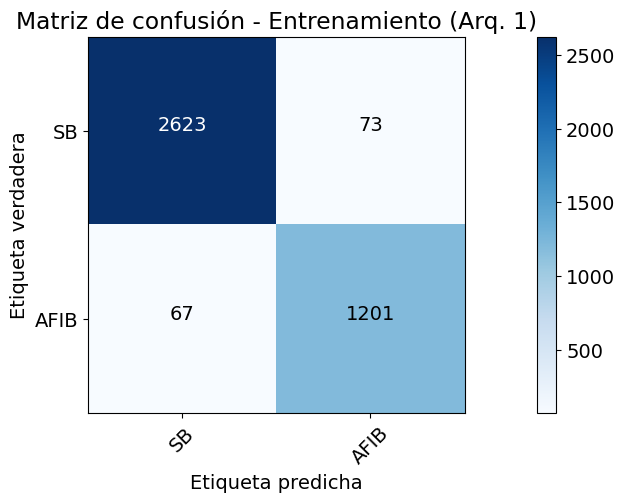

In [305]:
# Obtener la matriz de confusión para los datos de entrenamiento
mc_train = confusion_matrix(y_train, predict_train)

# Graficar la matriz de confusión de los datos de entrenamiento
target_names = ['SB', 'AFIB']  # Aquí adaptamos las clases a 'SB' y 'AFIB'
plot_confusion_matrix(mc_train, classes=target_names,title='Matriz de confusión - Entrenamiento (Arq. 1)')

Matriz de confusión, sin normalización
[[1143   49]
 [  33  475]]


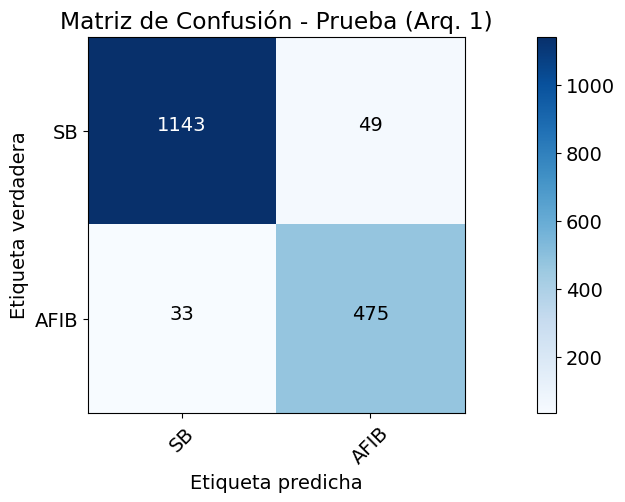

In [306]:
mc_test = confusion_matrix(y_test,predict_test)
plot_confusion_matrix(mc_test, classes=target_names,title='Matriz de Confusión - Prueba (Arq. 1)')

### Validación del Modelo de Aprendizaje 1

In [307]:
# Preparación de los datos
X = df[predictors].values
y = df[target_column].values

# Imputar valores faltantes
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Configuración de K-Fold
kf = KFold(n_splits=10, shuffle=True, random_state=40)  # 10 folds
final_score = 0
fold_runs = 0

# Validación cruzada
for train_idx, test_idx in kf.split(X_imputed):
    # Dividir datos en entrenamiento y prueba
    X_train, X_test = X_imputed[train_idx], X_imputed[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Crear el modelo
    mlp = MLPClassifier(hidden_layer_sizes=(145,145,145), activation='relu', solver='adam', max_iter=1000)

    # Entrenar el modelo
    mlp.fit(X_train, y_train)

    # Calcular precisión para este fold
    fold_score = mlp.score(X_test, y_test)
    final_score += fold_score
    fold_runs += 1

    # Matriz de confusión y reporte de clasificación
    cm = confusion_matrix(y_test, mlp.predict(X_test))
    print(f"Fold {fold_runs} - Precisión: {fold_score:.4f}")
    print("Matriz de confusión:")
    print(cm)

# Promedio final de precisión
average_accuracy = final_score / fold_runs
print(f"\nPrecisión promedio después de {fold_runs} folds: {average_accuracy:.4f}")

Fold 1 - Precisión: 0.9559
Matriz de confusión:
[[399  14]
 [ 11 143]]
Fold 2 - Precisión: 0.9594
Matriz de confusión:
[[368  16]
 [  7 176]]
Fold 3 - Precisión: 0.9506
Matriz de confusión:
[[380  16]
 [ 12 159]]
Fold 4 - Precisión: 0.9506
Matriz de confusión:
[[394  12]
 [ 16 145]]
Fold 5 - Precisión: 0.9435
Matriz de confusión:
[[377  18]
 [ 14 157]]
Fold 6 - Precisión: 0.9417
Matriz de confusión:
[[370  20]
 [ 13 163]]
Fold 7 - Precisión: 0.9452
Matriz de confusión:
[[365  17]
 [ 14 170]]
Fold 8 - Precisión: 0.9470
Matriz de confusión:
[[361  10]
 [ 20 175]]
Fold 9 - Precisión: 0.9664
Matriz de confusión:
[[359   7]
 [ 12 188]]
Fold 10 - Precisión: 0.9505
Matriz de confusión:
[[366  19]
 [  9 172]]

Precisión promedio después de 10 folds: 0.9511


### Curva de Pérdida del Modelo de Aprendizaje 1

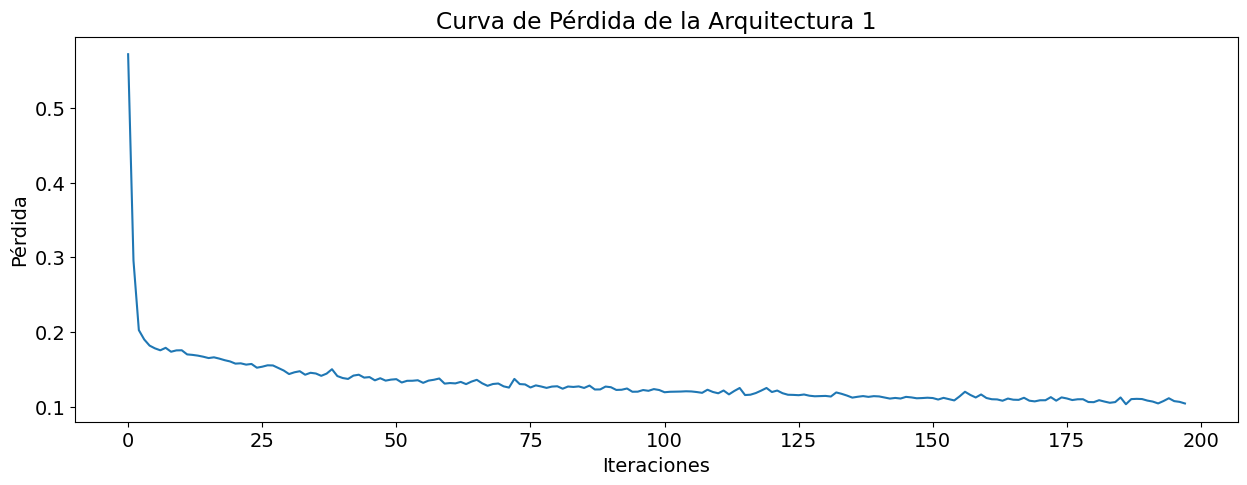

In [308]:
# Graficar la curva de pérdida
plt.plot(mlp.loss_curve_)

# Añadir título
plt.title("Curva de Pérdida de la Arquitectura 1")

# Añadir nombre al eje X
plt.xlabel("Iteraciones")

# Añadir nombre al eje Y
plt.ylabel("Pérdida")

# Mostrar la gráfica
plt.show()

<hr>

# Arquitectura 2: Factor 6

In [309]:
# Paso 1 - Crear arreglos para las características y la variable objetivo
target_column = ['Rythm']  # La columna que contiene las etiquetas (SB o AFIB)
predictors = list(set(list(df.columns))-set(target_column))  # Seleccionar las columnas que no sean 'Rythm'
print("Predictors:", predictors)  # Imprimir las columnas seleccionadas como predictores

# Excluir la columna 'FileName' de los predictores
predictors = [col for col in predictors if col != 'FileName']  # Filtrar 'FileName' para no incluirla en la normalización

# Filtrar solo las columnas numéricas para la normalización
numeric_predictors = df[predictors].select_dtypes(include=['number']).columns  # Seleccionar solo las columnas numéricas

# Normalizar solo las columnas numéricas
df[numeric_predictors] = df[numeric_predictors] / df[numeric_predictors].max()  # Normalización de las columnas numéricas

# Ver el resumen de estadísticas de las columnas después de la normalización
df.describe()  # Mostrar estadísticas descriptivas de las columnas


Predictors: ['Gender', 'FileName', 'AtrialRate', 'PhaseDiastolic', 'PhaseSystolic', 'fMP', 'QRSCount', 'QRSDuration', 'TOffsets', 'RRInterval', 'VentricularRate', 'PatientAge']


,Rythm,PatientAge,Gender,VentricularRate,AtrialRate,QRSCount,RRInterval,TOffsets,PhaseSystolic,PhaseDiastolic,QRSDuration,fMP
count,5664.000000,5664.000000,5664.000000,5664.000000,5663.000000,5664.000000,5664.000000,5627.000000,5664.000000,5664.000000,5664.000000,5664.000000
mean,0.313559,0.643320,0.621116,0.385614,0.462207,0.382111,0.444819,0.533065,0.393370,0.659307,0.452010,0.063889
std,0.463980,0.151711,0.485152,0.132238,0.110357,0.129420,0.107897,0.046784,0.134089,0.155961,0.077834,0.055949
min,0.000000,0.102041,0.000000,0.157868,0.143443,0.137931,0.157868,0.056146,0.133668,0.000000,0.271845,0.002000
25%,0.000000,0.540816,0.000000,0.308412,0.397711,0.310345,0.361168,0.513665,0.319549,0.638613,0.398058,0.024000
50%,0.000000,0.653061,1.000000,0.325633,0.420602,0.310345,0.484805,0.533771,0.348997,0.700000,0.436893,0.056000
75%,1.000000,0.755102,1.000000,0.437105,0.510666,0.413793,0.511875,0.553333,0.412281,0.747074,0.485437,0.076000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [310]:
# Paso 2 - Crear los conjuntos de entrenamiento y prueba
X = df[predictors].values  # Extraer las características (predictores) en una matriz de valores
y = df[target_column].values  # Extraer la variable objetivo ('Rythm') en una matriz de valores

# Se utiliza la misma semilla para la partición de los datos, asegurando que los resultados sean consistentes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)

# Se eliminan las dimensiones adicionales de y_train y y_test (en este caso, convertir de 2D a 1D)
y_test = np.squeeze(y_test)
y_train = np.squeeze(y_train)

# Imprimir las dimensiones de los conjuntos de entrenamiento y prueba
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de y_train:", y_train.shape)

print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_test:", y_test.shape)

Dimensiones de X_train: (3964, 11)
Dimensiones de y_train: (3964,)
Dimensiones de X_test: (1700, 11)
Dimensiones de y_test: (1700,)


In [311]:
# Paso 3 - Crear el Conjunto de Datos de Entrenamiento y Prueba
X = df[predictors].values
y = df[target_column].values

# El imputador para reemplazar NaN con la media de cada columna

imputer = SimpleImputer(strategy='mean')

# Imputamos los valores faltantes en los datos de entrenamiento y prueba
X_imputed = imputer.fit_transform(X)

# División en datos de entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.30, random_state=40)

# Aplanamos los datos de salida, si es necesario
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# Paso 4 - Entrenar el Modelo

# Creamos el clasificador MLP con 3 capas ocultas, cada una con 72 neuronas
mlp = MLPClassifier(hidden_layer_sizes=(72,72,72), activation='relu', solver='adam', max_iter=1000)
print(mlp)

# Entrenamos el clasificador utilizando los datos de entrenamiento
mlp.fit(X_train, y_train)

# Hacemos predicciones para los datos de entrenamiento y prueba
predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)




(3964, 11)
(3964,)
(1700, 11)
(1700,)
MLPClassifier(hidden_layer_sizes=(72, 72, 72), max_iter=1000)


In [312]:
# Resultados
# Matriz de confusión y reporte de clasificación para los datos de entrenamiento
from sklearn.metrics import confusion_matrix, classification_report

print("Matriz de confusión para los datos de entrenamiento:")
print(confusion_matrix(y_train, predict_train))

target_names = ['SB', 'AFIB']  
print("Reporte de clasificación para los datos de entrenamiento:")
print(classification_report(y_train, predict_train, target_names=target_names))

Matriz de confusión para los datos de entrenamiento:
[[2632   64]
 [  99 1169]]
Reporte de clasificación para los datos de entrenamiento:
              precision    recall  f1-score   support

          SB       0.96      0.98      0.97      2696
        AFIB       0.95      0.92      0.93      1268

    accuracy                           0.96      3964
   macro avg       0.96      0.95      0.95      3964
weighted avg       0.96      0.96      0.96      3964



In [313]:
# Matriz de confusión y reporte de clasificación para los datos de prueba
print("Matriz de confusión para los datos de prueba:")
print(confusion_matrix(y_test, predict_test))

print("Reporte de clasificación para los datos de prueba:")
print(classification_report(y_test, predict_test, target_names=target_names))

Matriz de confusión para los datos de prueba:
[[1147   45]
 [  37  471]]
Reporte de clasificación para los datos de prueba:
              precision    recall  f1-score   support

          SB       0.97      0.96      0.97      1192
        AFIB       0.91      0.93      0.92       508

    accuracy                           0.95      1700
   macro avg       0.94      0.94      0.94      1700
weighted avg       0.95      0.95      0.95      1700



Matriz de confusión, sin normalización
[[2632   64]
 [  99 1169]]


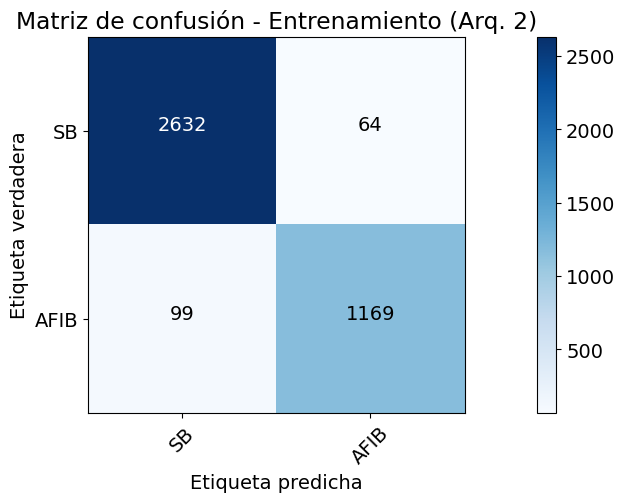

In [314]:
# Obtener la matriz de confusión para los datos de entrenamiento
mc_train = confusion_matrix(y_train, predict_train)

# Graficar la matriz de confusión de los datos de entrenamiento
target_names = ['SB', 'AFIB']  # Aquí adaptamos las clases a 'SB' y 'AFIB'
plot_confusion_matrix(mc_train, classes=target_names,title='Matriz de confusión - Entrenamiento (Arq. 2)')

Matriz de confusión, sin normalización
[[1147   45]
 [  37  471]]


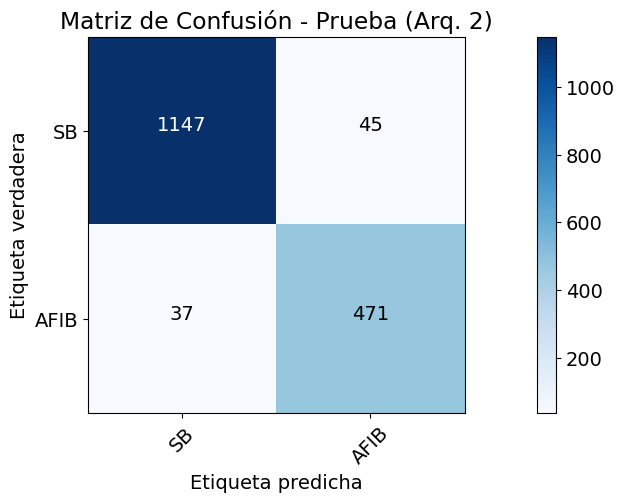

In [315]:
mc_test = confusion_matrix(y_test,predict_test)
plot_confusion_matrix(mc_test, classes=target_names,title='Matriz de Confusión - Prueba (Arq. 2)')

### Validación del Modelo de Aprendizaje 2

In [316]:
# Preparación de los datos
X = df[predictors].values
y = df[target_column].values

# Imputar valores faltantes
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Configuración de K-Fold
kf = KFold(n_splits=10, shuffle=True, random_state=40)  # 10 folds
final_score = 0
fold_runs = 0

# Validación cruzada
for train_idx, test_idx in kf.split(X_imputed):
    # Dividir datos en entrenamiento y prueba
    X_train, X_test = X_imputed[train_idx], X_imputed[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Crear el modelo
    mlp = MLPClassifier(hidden_layer_sizes=(72,72,72), activation='relu', solver='adam', max_iter=1000)

    # Entrenar el modelo
    mlp.fit(X_train, y_train)

    # Calcular precisión para este fold
    fold_score = mlp.score(X_test, y_test)
    final_score += fold_score
    fold_runs += 1

    # Matriz de confusión y reporte de clasificación
    cm = confusion_matrix(y_test, mlp.predict(X_test))
    print(f"Fold {fold_runs} - Precisión: {fold_score:.4f}")
    print("Matriz de confusión:")
    print(cm)

# Promedio final de precisión
average_accuracy = final_score / fold_runs
print(f"\nPrecisión promedio después de {fold_runs} folds: {average_accuracy:.4f}")

Fold 1 - Precisión: 0.9489
Matriz de confusión:
[[399  14]
 [ 15 139]]
Fold 2 - Precisión: 0.9541
Matriz de confusión:
[[366  18]
 [  8 175]]
Fold 3 - Precisión: 0.9489
Matriz de confusión:
[[381  15]
 [ 14 157]]
Fold 4 - Precisión: 0.9559
Matriz de confusión:
[[394  12]
 [ 13 148]]
Fold 5 - Precisión: 0.9435
Matriz de confusión:
[[381  14]
 [ 18 153]]
Fold 6 - Precisión: 0.9417
Matriz de confusión:
[[370  20]
 [ 13 163]]
Fold 7 - Precisión: 0.9558
Matriz de confusión:
[[368  14]
 [ 11 173]]
Fold 8 - Precisión: 0.9452
Matriz de confusión:
[[360  11]
 [ 20 175]]
Fold 9 - Precisión: 0.9594
Matriz de confusión:
[[356  10]
 [ 13 187]]
Fold 10 - Precisión: 0.9505
Matriz de confusión:
[[374  11]
 [ 17 164]]

Precisión promedio después de 10 folds: 0.9504


### Curva de Pérdida del Modelo de Aprendizaje 2

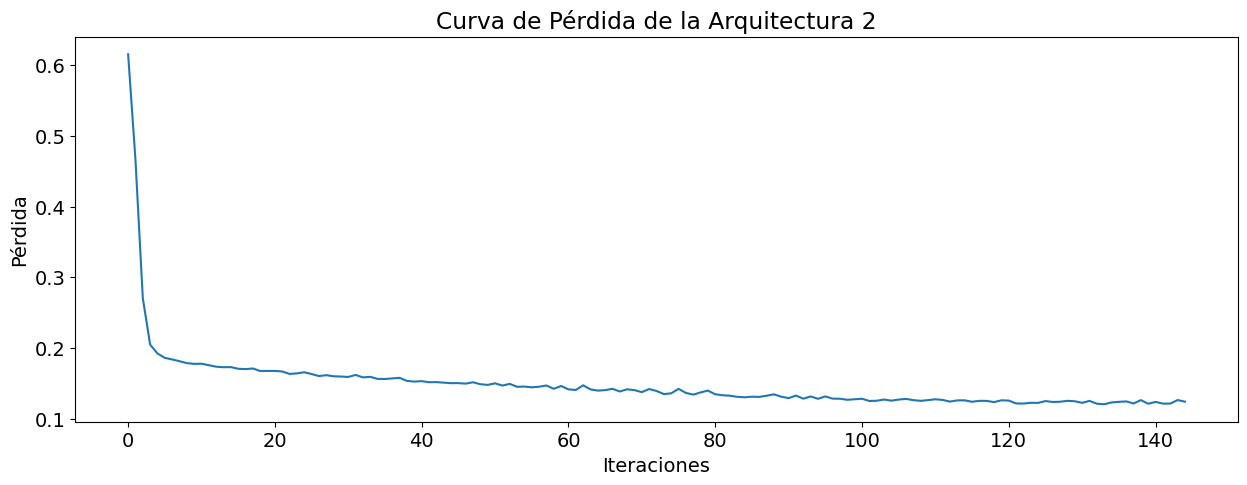

In [317]:
# Graficar la curva de pérdida
plt.plot(mlp.loss_curve_)

# Añadir título
plt.title("Curva de Pérdida de la Arquitectura 2")

# Añadir nombre al eje X
plt.xlabel("Iteraciones")

# Añadir nombre al eje Y
plt.ylabel("Pérdida")

# Mostrar la gráfica
plt.show()

<hr>

# Arquitectura 3: Factor 9

In [318]:
# Paso 1 - Crear arreglos para las características y la variable objetivo
target_column = ['Rythm']  # La columna que contiene las etiquetas (SB o AFIB)
predictors = list(set(list(df.columns))-set(target_column))  # Seleccionar las columnas que no sean 'Rythm'
print("Predictors:", predictors)  # Imprimir las columnas seleccionadas como predictores

# Excluir la columna 'FileName' de los predictores
predictors = [col for col in predictors if col != 'FileName']  # Filtrar 'FileName' para no incluirla en la normalización

# Filtrar solo las columnas numéricas para la normalización
numeric_predictors = df[predictors].select_dtypes(include=['number']).columns  # Seleccionar solo las columnas numéricas

# Normalizar solo las columnas numéricas
df[numeric_predictors] = df[numeric_predictors] / df[numeric_predictors].max()  # Normalización de las columnas numéricas

# Ver el resumen de estadísticas de las columnas después de la normalización
df.describe()  # Mostrar estadísticas descriptivas de las columnas


Predictors: ['Gender', 'FileName', 'AtrialRate', 'PhaseDiastolic', 'PhaseSystolic', 'fMP', 'QRSCount', 'QRSDuration', 'TOffsets', 'RRInterval', 'VentricularRate', 'PatientAge']


,Rythm,PatientAge,Gender,VentricularRate,AtrialRate,QRSCount,RRInterval,TOffsets,PhaseSystolic,PhaseDiastolic,QRSDuration,fMP
count,5664.000000,5664.000000,5664.000000,5664.000000,5663.000000,5664.000000,5664.000000,5627.000000,5664.000000,5664.000000,5664.000000,5664.000000
mean,0.313559,0.643320,0.621116,0.385614,0.462207,0.382111,0.444819,0.533065,0.393370,0.659307,0.452010,0.063889
std,0.463980,0.151711,0.485152,0.132238,0.110357,0.129420,0.107897,0.046784,0.134089,0.155961,0.077834,0.055949
min,0.000000,0.102041,0.000000,0.157868,0.143443,0.137931,0.157868,0.056146,0.133668,0.000000,0.271845,0.002000
25%,0.000000,0.540816,0.000000,0.308412,0.397711,0.310345,0.361168,0.513665,0.319549,0.638613,0.398058,0.024000
50%,0.000000,0.653061,1.000000,0.325633,0.420602,0.310345,0.484805,0.533771,0.348997,0.700000,0.436893,0.056000
75%,1.000000,0.755102,1.000000,0.437105,0.510666,0.413793,0.511875,0.553333,0.412281,0.747074,0.485437,0.076000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [319]:
# Paso 2 - Crear los conjuntos de entrenamiento y prueba
X = df[predictors].values  # Extraer las características (predictores) en una matriz de valores
y = df[target_column].values  # Extraer la variable objetivo ('Rythm') en una matriz de valores

# Se utiliza la misma semilla para la partición de los datos, asegurando que los resultados sean consistentes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)

# Se eliminan las dimensiones adicionales de y_train y y_test (en este caso, convertir de 2D a 1D)
y_test = np.squeeze(y_test)
y_train = np.squeeze(y_train)

# Imprimir las dimensiones de los conjuntos de entrenamiento y prueba
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de y_train:", y_train.shape)

print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_test:", y_test.shape)

Dimensiones de X_train: (3964, 11)
Dimensiones de y_train: (3964,)
Dimensiones de X_test: (1700, 11)
Dimensiones de y_test: (1700,)


In [320]:
# Paso 3 - Crear el Conjunto de Datos de Entrenamiento y Prueba
X = df[predictors].values
y = df[target_column].values

# El imputador para reemplazar NaN con la media de cada columna

imputer = SimpleImputer(strategy='mean')

# Imputamos los valores faltantes en los datos de entrenamiento y prueba
X_imputed = imputer.fit_transform(X)

# División en datos de entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.30, random_state=40)

# Aplanamos los datos de salida, si es necesario
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# Paso 4 - Entrenar el Modelo

# Creamos el clasificador MLP con 3 capas ocultas, cada una con 48 neuronas
mlp = MLPClassifier(hidden_layer_sizes=(48,48,48), activation='relu', solver='adam', max_iter=1000)
print(mlp)

# Entrenamos el clasificador utilizando los datos de entrenamiento
mlp.fit(X_train, y_train)

# Hacemos predicciones para los datos de entrenamiento y prueba
predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test)


(3964, 11)
(3964,)
(1700, 11)
(1700,)
MLPClassifier(hidden_layer_sizes=(48, 48, 48), max_iter=1000)


In [321]:
# Matriz de confusión y reporte de clasificación para los datos de entrenamiento
from sklearn.metrics import confusion_matrix, classification_report

print("Matriz de confusión para los datos de entrenamiento:")
print(confusion_matrix(y_train, predict_train))

target_names = ['SB', 'AFIB']  
print("Reporte de clasificación para los datos de entrenamiento:")
print(classification_report(y_train, predict_train, target_names=target_names))

Matriz de confusión para los datos de entrenamiento:
[[2586  110]
 [  75 1193]]
Reporte de clasificación para los datos de entrenamiento:
              precision    recall  f1-score   support

          SB       0.97      0.96      0.97      2696
        AFIB       0.92      0.94      0.93      1268

    accuracy                           0.95      3964
   macro avg       0.94      0.95      0.95      3964
weighted avg       0.95      0.95      0.95      3964



In [322]:
# Matriz de confusión y reporte de clasificación para los datos de prueba
print("Matriz de confusión para los datos de prueba:")
print(confusion_matrix(y_test, predict_test))

print("Reporte de clasificación para los datos de prueba:")
print(classification_report(y_test, predict_test, target_names=target_names))

Matriz de confusión para los datos de prueba:
[[1137   55]
 [  29  479]]
Reporte de clasificación para los datos de prueba:
              precision    recall  f1-score   support

          SB       0.98      0.95      0.96      1192
        AFIB       0.90      0.94      0.92       508

    accuracy                           0.95      1700
   macro avg       0.94      0.95      0.94      1700
weighted avg       0.95      0.95      0.95      1700



Matriz de confusión, sin normalización
[[2586  110]
 [  75 1193]]


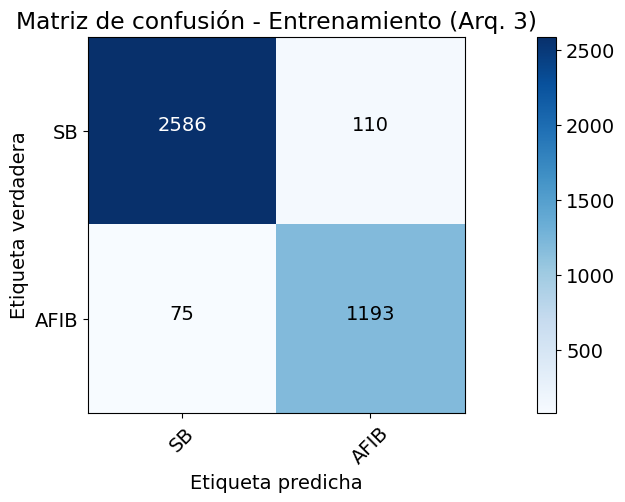

In [323]:
# Obtener la matriz de confusión para los datos de entrenamiento
mc_train = confusion_matrix(y_train, predict_train)

# Graficar la matriz de confusión de los datos de entrenamiento
target_names = ['SB', 'AFIB']  # Aquí adaptamos las clases a 'SB' y 'AFIB'
plot_confusion_matrix(mc_train, classes=target_names,title='Matriz de confusión - Entrenamiento (Arq. 3)')

Matriz de confusión, sin normalización
[[1137   55]
 [  29  479]]


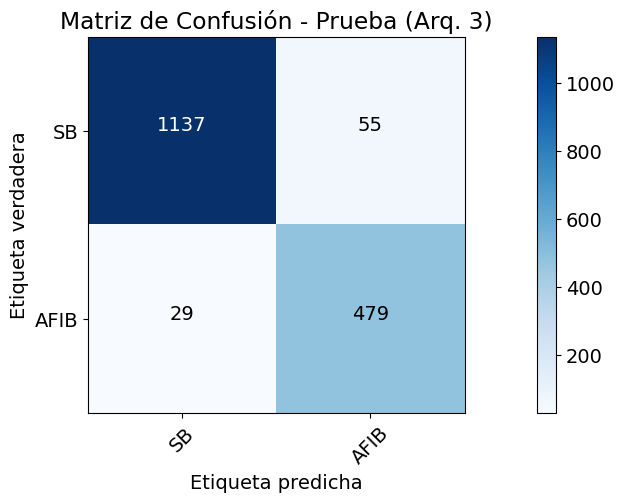

In [324]:
mc_test = confusion_matrix(y_test,predict_test)
plot_confusion_matrix(mc_test, classes=target_names,title='Matriz de Confusión - Prueba (Arq. 3)')

In [325]:
# Preparación de los datos
X = df[predictors].values
y = df[target_column].values

# Imputar valores faltantes
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Configuración de K-Fold
kf = KFold(n_splits=10, shuffle=True, random_state=40)  # 10 folds
final_score = 0
fold_runs = 0

# Validación cruzada
for train_idx, test_idx in kf.split(X_imputed):
    # Dividir datos en entrenamiento y prueba
    X_train, X_test = X_imputed[train_idx], X_imputed[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Crear el modelo
    mlp = MLPClassifier(hidden_layer_sizes=(48,48,48), activation='relu', solver='adam', max_iter=1000)

    # Entrenar el modelo
    mlp.fit(X_train, y_train)

    # Calcular precisión para este fold
    fold_score = mlp.score(X_test, y_test)
    final_score += fold_score
    fold_runs += 1

    # Matriz de confusión y reporte de clasificación
    cm = confusion_matrix(y_test, mlp.predict(X_test))
    print(f"Fold {fold_runs} - Precisión: {fold_score:.4f}")
    print("Matriz de confusión:")
    print(cm)

# Promedio final de precisión
average_accuracy = final_score / fold_runs
print(f"\nPrecisión promedio después de {fold_runs} folds: {average_accuracy:.4f}")

Fold 1 - Precisión: 0.9453
Matriz de confusión:
[[397  16]
 [ 15 139]]
Fold 2 - Precisión: 0.9524
Matriz de confusión:
[[366  18]
 [  9 174]]
Fold 3 - Precisión: 0.9436
Matriz de confusión:
[[383  13]
 [ 19 152]]
Fold 4 - Precisión: 0.9524
Matriz de confusión:
[[395  11]
 [ 16 145]]
Fold 5 - Precisión: 0.9435
Matriz de confusión:
[[382  13]
 [ 19 152]]
Fold 6 - Precisión: 0.9470
Matriz de confusión:
[[371  19]
 [ 11 165]]
Fold 7 - Precisión: 0.9541
Matriz de confusión:
[[372  10]
 [ 16 168]]
Fold 8 - Precisión: 0.9452
Matriz de confusión:
[[356  15]
 [ 16 179]]
Fold 9 - Precisión: 0.9629
Matriz de confusión:
[[358   8]
 [ 13 187]]
Fold 10 - Precisión: 0.9488
Matriz de confusión:
[[372  13]
 [ 16 165]]

Precisión promedio después de 10 folds: 0.9495


### Curva de Pérdida del Modelo de Aprendizaje 3

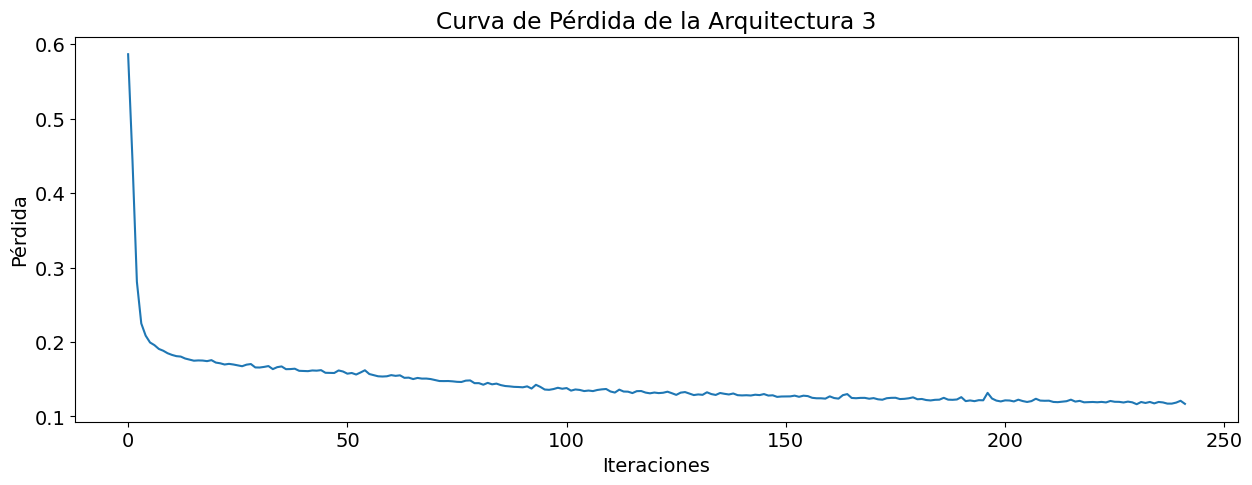

In [326]:
# Graficar la curva de pérdida
plt.plot(mlp.loss_curve_)

# Añadir título
plt.title("Curva de Pérdida de la Arquitectura 3")

# Añadir nombre al eje X
plt.xlabel("Iteraciones")

# Añadir nombre al eje Y
plt.ylabel("Pérdida")

# Mostrar la gráfica
plt.show()

<hr>

# Algortimo K-means

In [327]:
from sklearn.cluster import KMeans

# Crear el Conjunto de Datos de Entrenamiento y Prueba
X = df[predictors].values
y = df[target_column].values

# El imputador para reemplazar NaN con la media de cada columna
imputer = SimpleImputer(strategy='mean')

# Imputamos los valores faltantes en los datos de entrenamiento y prueba
X_imputed = imputer.fit_transform(X)

# División en datos de entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.30, random_state=40)

# Aplanamos los datos de salida, si es necesario
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

# Crear el modelo K-means con 2 clústeres (uno para SB y otro para AFIB)
kmeans = KMeans(n_clusters=2, random_state=40)

# Ajustar el modelo con los datos de entrenamiento
kmeans.fit(X_train)

# Predecir las etiquetas (clusters) para los datos de entrenamiento y prueba
predict_train_kmeans = kmeans.predict(X_train)
predict_test_kmeans = kmeans.predict(X_test)

target_names = ['SB', 'AFIB']

# Reporte de clasificación para el conjunto de entrenamiento
print("Reporte de clasificación usando K-means para los datos de entrenamiento:")
print(classification_report(y_train, predict_train_kmeans, target_names=target_names))

# Reporte de clasificación para el conjunto de prueba
print("Reporte de clasificación usando K-means para los datos de prueba:")
print(classification_report(y_test, predict_test_kmeans, target_names=target_names))


Reporte de clasificación usando K-means para los datos de entrenamiento:
              precision    recall  f1-score   support

          SB       0.66      0.36      0.47      2696
        AFIB       0.31      0.60      0.41      1268

    accuracy                           0.44      3964
   macro avg       0.48      0.48      0.44      3964
weighted avg       0.55      0.44      0.45      3964

Reporte de clasificación usando K-means para los datos de prueba:
              precision    recall  f1-score   support

          SB       0.65      0.36      0.46      1192
        AFIB       0.27      0.55      0.36       508

    accuracy                           0.42      1700
   macro avg       0.46      0.45      0.41      1700
weighted avg       0.54      0.42      0.43      1700



<hr>

# Máquinas de Soporte Vectorial (SVM)

In [328]:
from sklearn import svm

# Crear el Conjunto de Datos de Entrenamiento y Prueba
X = df[predictors].values
y = df[target_column].values

# El imputador para reemplazar NaN con la media de cada columna
imputer = SimpleImputer(strategy='mean')

# Imputamos los valores faltantes en los datos de entrenamiento y prueba
X_imputed = imputer.fit_transform(X)

# División en datos de entrenamiento y prueba (70% entrenamiento, 30% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.30, random_state=40)

# Aplanamos los datos de salida, si es necesario
y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

# Crear el modelo 
clf = svm.NuSVC(gamma='auto')
clf.fit(X_train,y_train)

# Predecir las etiquetas para los datos de entrenamiento y prueba
predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

target_names = ['SB', 'AFIB']

# Reporte de clasificación para el conjunto de entrenamiento
print("Reporte de clasificación usando SVM para los datos de entrenamiento:")
print(classification_report(y_train,predict_train,target_names=target_names))

# Reporte de clasificación para el conjunto de prueba
print("Reporte de clasificación usando SVM para los datos de prueba:")
print(classification_report(y_test,predict_test,target_names=target_names))


Reporte de clasificación usando SVM para los datos de entrenamiento:
              precision    recall  f1-score   support

          SB       0.86      0.98      0.92      2696
        AFIB       0.94      0.66      0.78      1268

    accuracy                           0.88      3964
   macro avg       0.90      0.82      0.85      3964
weighted avg       0.89      0.88      0.87      3964

Reporte de clasificación usando SVM para los datos de prueba:
              precision    recall  f1-score   support

          SB       0.88      0.97      0.92      1192
        AFIB       0.91      0.70      0.79       508

    accuracy                           0.89      1700
   macro avg       0.90      0.83      0.86      1700
weighted avg       0.89      0.89      0.88      1700

